In [1]:
#The only thing to include in the paper/presentation from this code is the bar graph
import random
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
#import wfdb
import copy as cp
import scipy.signal as signal
import pickle
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import csv

from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from time import time
import timeit

random.seed(1000)

In [2]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

#sns.set(rc={'figure.figsize':(11.7,8.27)})

/var/folders/lh/98dp9hg53bjb8v17_1dc51k00000gn/T/ipykernel_2297/3159236473.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


# Side to side comparison plots

In [3]:
statallfeatures_dic = {
    'Run Time': [],
    'Accuracy': [],   ## To store the MEAN accuracy for 5-fold CV for each model
    'Standard Error': [],
    'Sensitivity': [],
    'Specificity': [],
    'Precision': [],
    'F1_Score': []   
}

In [4]:
## To store the accuracy for 5-fold CV for each model
indaccs_dic = {}

2017 train -> 2021 test

In [5]:
train_df = pd.read_csv('JORN21_dataset_v1.csv', na_values='?').dropna()
test_df = pd.read_csv('SRER_2017_training_bi.csv', na_values='?').dropna()
train_df
test_df

,OID_,Id,gridcode,Shape_Length,Shape_Area,CH_mean,ARVI_max,ARVI_mean,ARVI_med,EVI_max,EVI_mean,EVI_med,NDVI_max,NDVI_mean,NDVI_med,SAVI_max,SAVI_mean,SAVI_med,Veg_class
0,1,2,2,41.6,17.41,0.190714,0.609099,0.344183,0.379428,0.443455,0.292047,0.290985,0.665698,0.476709,0.507514,0.406991,0.286203,0.288351,woody
1,2,3,3,31.4,5.05,0.045000,0.387755,0.245301,0.274936,0.332059,0.252919,0.244477,0.526375,0.406745,0.433791,0.328585,0.254814,0.248126,non-woody
2,3,5,5,33.4,4.84,0.010000,0.038844,0.004040,0.026805,0.150550,0.131985,0.134891,0.208300,0.181575,0.205117,0.150184,0.131642,0.135063,non-woody
3,4,6,6,32.2,14.20,0.011667,0.189842,0.033418,0.018961,0.198972,0.141579,0.138338,0.341480,0.207390,0.197327,0.197330,0.141500,0.138725,non-woody
4,5,7,7,28.8,10.73,0.013750,0.322694,0.080315,0.061453,0.248442,0.158710,0.142326,0.457103,0.247391,0.228112,0.248598,0.158618,0.142817,non-woody
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4334,4335,4487,4487,8.8,2.30,0.020000,0.290182,0.290182,0.290182,0.283959,0.283959,0.283959,0.419200,0.419200,0.419200,0.269486,0.269486,0.269486,woody
4335,4336,4488,4488,10.8,2.03,0.020000,0.408320,0.408320,0.408320,0.372648,0.372648,0.372648,0.510469,0.510469,0.510469,0.340879,0.340879,0.340879,woody
4336,4337,4489,4489,11.8,2.62,0.015000,0.437195,0.413297,0.413297,0.235606,0.234926,0.234926,0.499074,0.485601,0.485601,0.227606,0.226722,0.226722,woody
4337,4338,4490,4490,11.2,3.09,0.015000,0.570094,0.550652,0.550652,0.416298,0.388085,0.388085,0.640722,0.621694,0.621694,0.387576,0.363288,0.363288,woody


In [6]:
#Logistic Regression

kf = KFold(n_splits=5, random_state=3, shuffle=True)
model = LogisticRegression(solver='liblinear')

start_time = timeit.default_timer()

acc_score = []
Truth = []
Output = []

testindex8 = []
testindex9 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)

    testindex8.append(test_index)
    testindex9.append(pred_values)
    
elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LogReg']=acc_score

---Run time is 0.045693585000000425 seconds ---

Accuracy of each fold: 
 [0.6853146853146853, 0.6565420560747663, 0.6214953271028038, 0.6799065420560748, 0.6635514018691588]
Avg accuracy: 0.6613620024834979
Std of accuracy : 
0.022516696568248874

[[903 200]
 [525 513]]

              precision    recall  f1-score   support

   non-woody       0.63      0.82      0.71      1103
       woody       0.72      0.49      0.59      1038

    accuracy                           0.66      2141
   macro avg       0.68      0.66      0.65      2141
weighted avg       0.67      0.66      0.65      2141

0.8186763372620127
0.49421965317919075
0.6323529411764706
0.713551955748716


/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/bas

In [7]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed = woodyarea1/totalarea1 * 100
print(needed)

---Run time is 0.14198519099999984 seconds ---
32.64896265570256


In [8]:
woodyarea4 = 0
nonwoodyarea4 = 0
totalarea4 = 0

start_time = timeit.default_timer()

for i in testindex8:
    for j in i:
        for k in range(0,5):
            for l in testindex9[k]:
                if l == "woody":
                    woodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea4 += test_df.iat[j,4]
                    totalarea4 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC4 = woodyarea4/totalarea4 * 100
                    
print(FWC4)

---Run time is 129.58914707300002 seconds ---
33.30219523592326


In [9]:
#LDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=LinearDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex1 = []
testindex2 = []
for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex1.append(test_index)
    testindex2.append(pred_values)

elapsed = timeit.default_timer() - start_time



print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['LDA']=acc_score

---Run time is 129.69192141300002 seconds ---

Accuracy of each fold: 
 [0.5990675990675991, 0.572429906542056, 0.5350467289719626, 0.6051401869158879, 0.5981308411214953]
Avg accuracy: 0.5819630525238002
Std of accuracy : 
0.026012169256590625

[[974 129]
 [766 272]]

              precision    recall  f1-score   support

   non-woody       0.56      0.88      0.69      1103
       woody       0.68      0.26      0.38      1038

    accuracy                           0.58      2141
   macro avg       0.62      0.57      0.53      2141
weighted avg       0.62      0.58      0.54      2141

0.8830462375339981
0.26204238921001927
0.5597701149425287
0.6851916989096025


/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/bas

In [10]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
print(woodyarea1/totalarea1 * 100)

needed2 = woodyarea1/totalarea1 * 100
print(needed2)

---Run time is 0.1780410720000134 seconds ---
32.64896265570256
32.64896265570256


In [11]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0
start_time = timeit.default_timer()

for i in testindex1:
    for j in i:
        for k in range(0,5):
            for l in testindex2[k]:
                if l == "woody":
                    woodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea1 += test_df.iat[j,4]
                    totalarea1 += test_df.iat[j,4]

                    
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC = woodyarea1/totalarea1 * 100
                    
print(FWC)

---Run time is 136.013978069 seconds ---
18.729565623559672


In [12]:
print(woodyarea1)
print(nonwoodyarea1)
print(totalarea1)

7006472.499973674
30402149.999961354
37408622.49982095


In [13]:
#QDA
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=QuadraticDiscriminantAnalysis()

acc_score = []
Truth = []
Output = []

testindex3 = []
testindex4 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]


    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)


    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    #makes the list for FWC
    testindex3.append(test_index)
    testindex4.append(pred_values)

elapsed = timeit.default_timer() - start_time


print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['QDA']=acc_score

---Run time is 136.071887416 seconds ---

Accuracy of each fold: 
 [0.5571095571095571, 0.602803738317757, 0.5864485981308412, 0.5771028037383178, 0.5794392523364486]
Avg accuracy: 0.5805807899265842
Std of accuracy : 
0.014782346730240294

[[405 698]
 [200 838]]

              precision    recall  f1-score   support

   non-woody       0.67      0.37      0.47      1103
       woody       0.55      0.81      0.65      1038

    accuracy                           0.58      2141
   macro avg       0.61      0.59      0.56      2141
weighted avg       0.61      0.58      0.56      2141

0.3671804170444243
0.8073217726396917
0.6694214876033058
0.47423887587822006


/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/bas

In [14]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed3 = woodyarea1/totalarea1 * 100
print(needed3)

---Run time is 0.15150445299997273 seconds ---
32.64896265570256


In [15]:
woodyarea2 = 0
nonwoodyarea2 = 0
totalarea2 = 0
start_time = timeit.default_timer()

for i in testindex3:
    for j in i:
        for k in range(0,5):
            for l in testindex4[k]:
                if l == "woody":
                    woodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea2 += test_df.iat[j,4]
                    totalarea2 += test_df.iat[j,4]
elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC2 = woodyarea2/totalarea2 * 100
                    
print(FWC2)

---Run time is 122.966547032 seconds ---
71.74217655329245


In [16]:
print(woodyarea2)
print(nonwoodyarea2)
print(totalarea2)
print(FWC2)

26837759.99997623
10570862.499970367
37408622.49982095
71.74217655329245


#KNN-CV
KNN_result = []
X=subject_df.iloc[:, 2:17]
Y=subject_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,26):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

In [17]:
KNN_result = []
X=train_df.iloc[:, 5:18]
Y=train_df.iloc[:, -1]
crossvalidation = KFold(n_splits=5, random_state=3, shuffle=True)
KNNResult = []
for k in range(1,11):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    model = knn.fit(X, Y)
    scores=cross_val_score(model, X, Y, cv=crossvalidation)
    print('K={}'.format(k))
    print()
    print('Accuracy of each fold: \n {}'.format(scores))
    print()
    print("Avg accuracy: {}".format(scores.mean()))
    print()
    KNN_result.append(scores.mean())
print(KNN_result)

K=1

Accuracy of each fold: 
 [0.77855478 0.78271028 0.78037383 0.77336449 0.8271028 ]

Avg accuracy: 0.7884212360847874

K=2

Accuracy of each fold: 
 [0.78088578 0.75700935 0.76635514 0.7546729  0.78271028]

Avg accuracy: 0.7683266888874364

K=3

Accuracy of each fold: 
 [0.81818182 0.81542056 0.81074766 0.79672897 0.84345794]

Avg accuracy: 0.8169073916737469

K=4

Accuracy of each fold: 
 [0.80885781 0.79672897 0.80140187 0.78504673 0.83878505]

Avg accuracy: 0.8061640851360478

K=5

Accuracy of each fold: 
 [0.82051282 0.8364486  0.81308411 0.81542056 0.84813084]

Avg accuracy: 0.8267193865324705

K=6

Accuracy of each fold: 
 [0.81118881 0.8364486  0.80841121 0.79205607 0.84813084]

Avg accuracy: 0.8192471080321548

K=7

Accuracy of each fold: 
 [0.81585082 0.85981308 0.81775701 0.82009346 0.83878505]

Avg accuracy: 0.8304598827963314

K=8

Accuracy of each fold: 
 [0.81351981 0.85514019 0.81074766 0.80607477 0.84345794]

Avg accuracy: 0.8257880748534955

K=9

Accuracy of each fo

In [18]:
#KNN-CV
kf = KFold(n_splits=5, random_state=3, shuffle=True)
model=neighbors.KNeighborsClassifier(n_neighbors=9)

acc_score = []
Truth = []
Output = []

testindex5 = []
testindex6 = []

for train_index, test_index in kf.split(train_df): 
    X_train = train_df.iloc[train_index, 5:18]
    X_test = test_df.iloc[test_index, 5:18]
    Y_train = train_df.iloc[train_index, -1]
    Y_test = test_df.iloc[test_index, -1]

    model.fit(X_train, Y_train)
    pred_values = model.predict(X_test)

    acc = accuracy_score(Y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(Y_test.values.reshape(Y_test.shape[0])) 
    Output.extend(pred_values)
    
    testindex5.append(test_index)
    testindex6.append(pred_values)


elapsed = timeit.default_timer() - start_time

print()
print("---Run time is %s seconds ---" % elapsed)
print()
print('Accuracy of each fold: \n {}'.format(acc_score))
print("Avg accuracy: {}".format(np.mean(acc_score)))
print('Std of accuracy : \n{}'.format(np.std(acc_score)))
print()
print(confusion_matrix(Truth, Output))
print()
print(classification_report(Truth, Output))

cm = confusion_matrix(Truth, Output)

sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
specificity = cm[1][1]/(cm[1][0]+cm[1][1])
precision = (cm[0][0])/(cm[0][0]+cm[1][0])
f1_score = (2*precision*sensitivity)/(precision+sensitivity)

print(sensitivity)
print(specificity)
print(precision)
print(f1_score)

statallfeatures_dic['Run Time'].append(elapsed)
statallfeatures_dic['Accuracy'].append(np.mean(acc_score))
statallfeatures_dic['Standard Error'].append(np.std(acc_score))
statallfeatures_dic['Sensitivity'].append(sensitivity)
statallfeatures_dic['Specificity'].append(specificity)
statallfeatures_dic['Precision'].append(precision)
statallfeatures_dic['F1_Score'].append(f1_score)

indaccs_dic['KNN']=acc_score


---Run time is 124.13606901499998 seconds ---

Accuracy of each fold: 
 [0.6317016317016317, 0.6098130841121495, 0.5467289719626168, 0.6588785046728972, 0.6214953271028038]
Avg accuracy: 0.6137235039104199
Std of accuracy : 
0.037218670321154834

[[1005   98]
 [ 729  309]]

              precision    recall  f1-score   support

   non-woody       0.58      0.91      0.71      1103
       woody       0.76      0.30      0.43      1038

    accuracy                           0.61      2141
   macro avg       0.67      0.60      0.57      2141
weighted avg       0.67      0.61      0.57      2141

0.9111514052583862
0.2976878612716763
0.5795847750865052
0.7084948889672189


/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/Users/sophiemao/opt/anaconda3/lib/python3.9/site-packages/sklearn/bas

In [19]:
woodyarea1 = 0
nonwoodyarea1 = 0
totalarea1 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        totalarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "woody":
            woodyarea1 += test_df.iat[j,4]
        if test_df.iat[j,-1] == "non-woody":
            nonwoodyarea1 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
needed4 = woodyarea1/totalarea1 * 100
print(needed4)

---Run time is 0.11645120700001144 seconds ---
32.64896265570256


In [20]:
woodyarea3 = 0
nonwoodyarea3 = 0
totalarea3 = 0

start_time = timeit.default_timer()

for i in testindex5:
    for j in i:
        for k in range(0,5):
            for l in testindex6[k]:
                if l == "woody":
                    woodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]
                if l == "non-woody":
                    nonwoodyarea3 += test_df.iat[j,4]
                    totalarea3 += test_df.iat[j,4]

elapsed = timeit.default_timer() - start_time
print("---Run time is %s seconds ---" % elapsed)
FWC3 = woodyarea3/totalarea3 * 100
                    
print(FWC3)

---Run time is 126.71874506299997 seconds ---
19.00980850071967


In [21]:
transitionsdf = pd.DataFrame(
    data = np.transpose(np.array([
                                statallfeatures_dic["Accuracy"],
                                statallfeatures_dic["Standard Error"],
                                statallfeatures_dic["Sensitivity"],
                                statallfeatures_dic["Specificity"],
                                statallfeatures_dic["Precision"],
                                statallfeatures_dic["F1_Score"],
                                statallfeatures_dic["Run Time"] 
                            ])
                       ),
    
    columns = ["Accuracy", "Standard Error", "Sensitivity", "Specificity", "Precision", "F1-Score", "Run Time"]
    
)

transitionsdf.set_index(pd.Index(["LogReg", "LDA", "QDA", "KNN-CV"]))

,Accuracy,Standard Error,Sensitivity,Specificity,Precision,F1-Score,Run Time
LogReg,0.661362,0.022517,0.818676,0.494220,0.632353,0.713552,0.045694
LDA,0.581963,0.026012,0.883046,0.262042,0.559770,0.685192,129.691921
QDA,0.580581,0.014782,0.367180,0.807322,0.669421,0.474239,136.071887
KNN-CV,0.613724,0.037219,0.911151,0.297688,0.579585,0.708495,124.136069


['LogReg', 'LDA', 'QDA', 'KNN-CV']
Accuracies[0.6613620024834979, 0.5819630525238002, 0.5805807899265842, 0.6137235039104199]
Sen[0.8186763372620127, 0.8830462375339981, 0.3671804170444243, 0.9111514052583862]
Spec[0.49421965317919075, 0.26204238921001927, 0.8073217726396917, 0.2976878612716763]
P[0.6323529411764706, 0.5597701149425287, 0.6694214876033058, 0.5795847750865052]
F1[0.713551955748716, 0.6851916989096025, 0.47423887587822006, 0.7084948889672189]


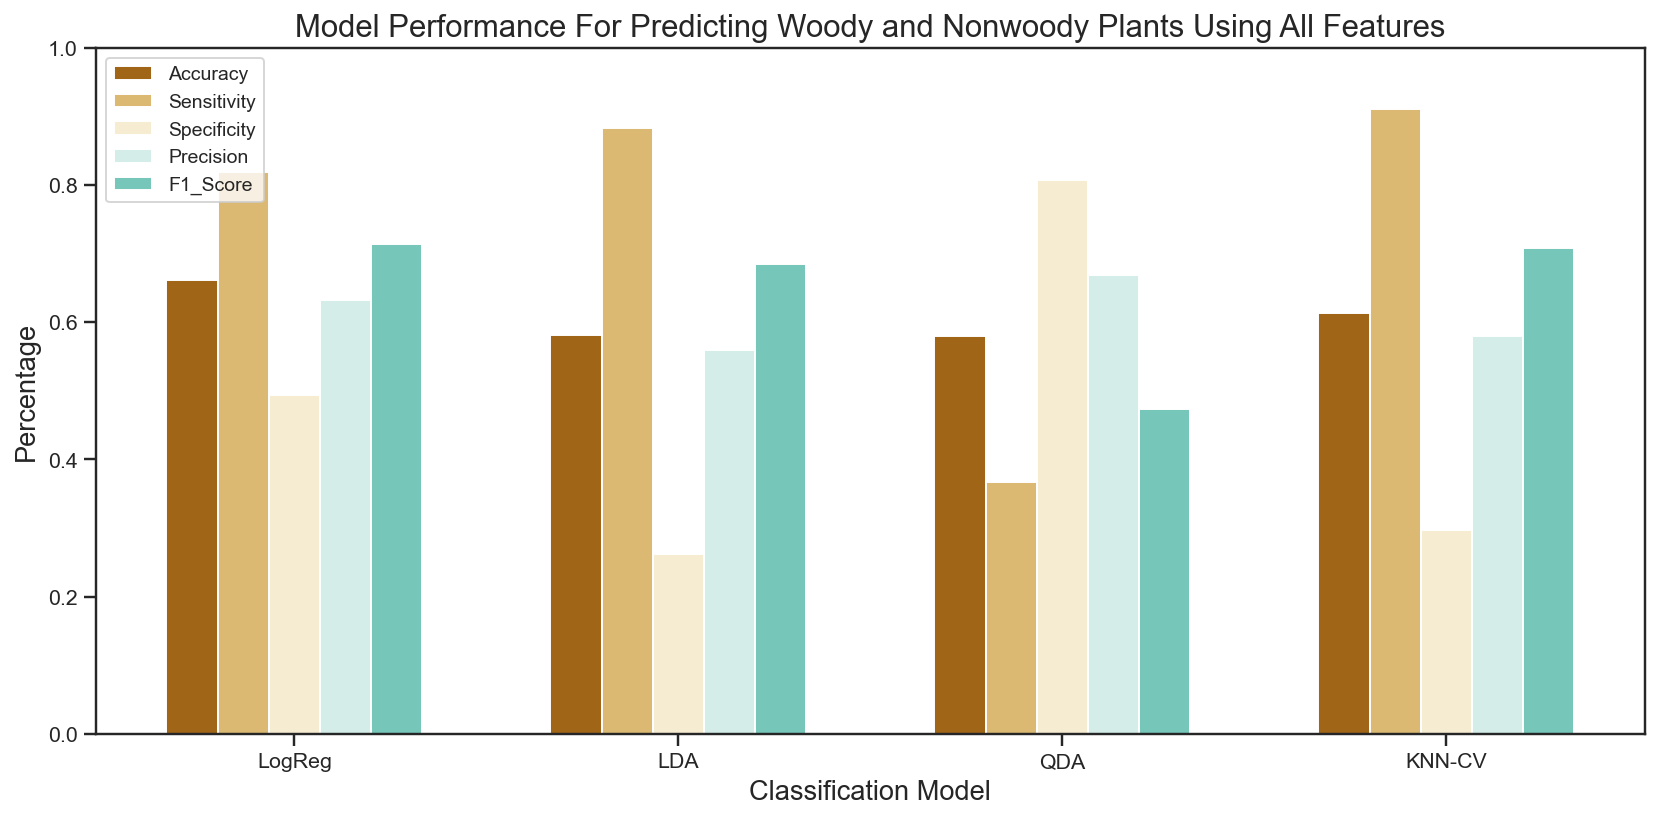

In [22]:
#Bar Graph
models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']
print(models)
accuracies = statallfeatures_dic["Accuracy"]
print("Accuracies" + str(accuracies))
sensitivities = statallfeatures_dic["Sensitivity"]
print("Sen" + str(sensitivities))
specificities = statallfeatures_dic["Specificity"]
print("Spec" + str(specificities))
precisions = statallfeatures_dic["Precision"]
print("P" + str(precisions))
f1_scores = statallfeatures_dic["F1_Score"]
print("F1" + str(f1_scores))

x = 6*np.arange(len(models))
width = 0.8

fig, ax = plt.subplots(figsize=(12, 6))
import seaborn as sns
colors = sns.color_palette("BrBG")

acc = ax.bar(x-width*2, accuracies, width, label='Accuracy', color=colors[0])
sen = ax.bar(x-width, sensitivities, width, label='Sensitivity', color=colors[1])
spe = ax.bar(x,specificities, width, label='Specificity', color=colors[2])
pre = ax.bar(x+width, precisions, width, label='Precision', color=colors[3])
f1 = ax.bar(x+width*2 , f1_scores, width, label='F1_Score', color=colors[4])

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Percentage', fontsize=14)
ax.set_title('Model Performance For Predicting Woody and Nonwoody Plants Using All Features', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set(ylim=(0.0, 1))


fig.tight_layout()

plt.legend(loc="upper left", prop={'size': 10})
plt.show()

fig.savefig('AllFeaturesPerformance.png')

#Code from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

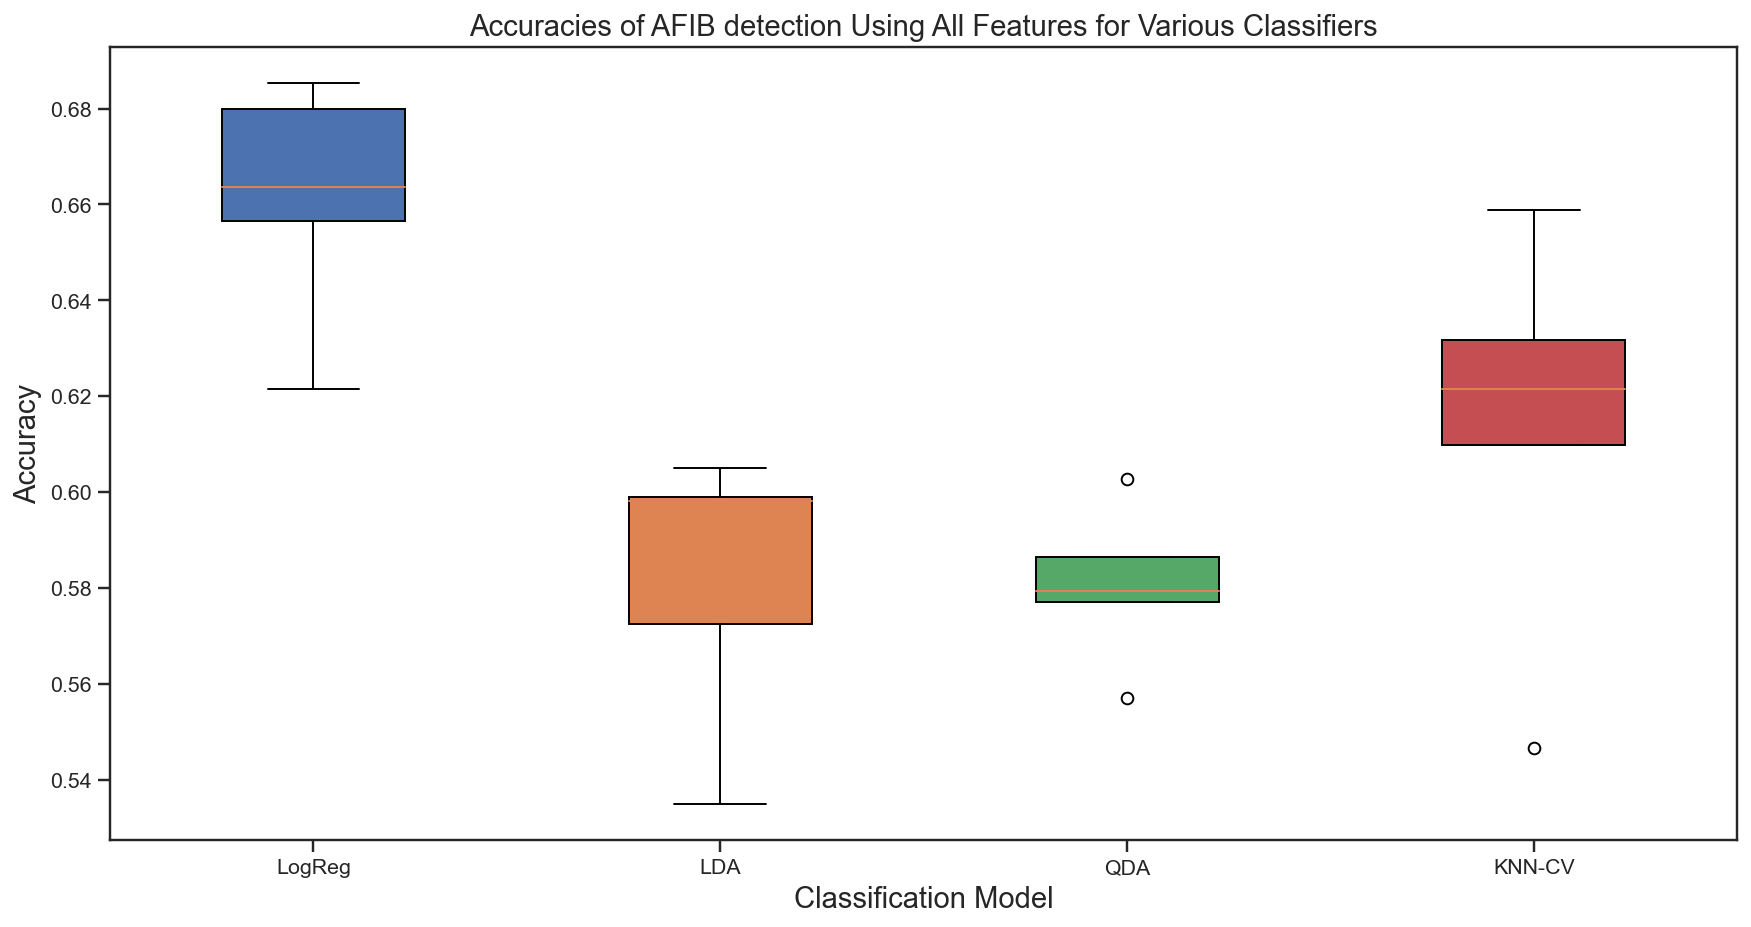

In [23]:
#Box Plot Accuracies

models = ['LogReg', 'LDA', 'QDA', 'KNN-CV']

x = np.arange(len(models))+1

LogRegAcc = indaccs_dic['LogReg']
LDAAcc = indaccs_dic['LDA']
QDAAcc = indaccs_dic['QDA']
KNNAcc = indaccs_dic['KNN']

data = [LogRegAcc, LDAAcc, QDAAcc, KNNAcc]

fig, ax = plt.subplots(figsize = (15,7.5))
bplot = ax.boxplot(data, patch_artist = True)

ax.set_title('Accuracies of AFIB detection Using All Features for Various Classifiers', fontsize=15)
ax.set_xlabel('Classification Model', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xticks(x)
ax.set_xticklabels(models)

import seaborn as sns
#colors = sns.color_palette("colorblind")
colors = sns.color_palette()

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
plt.show()

In [24]:
print("Log reg act: " + str(needed))
print("Log reg pred: " + str(FWC4))
print("QDA act: " + str(needed2))
print("QDA pred: " + str(FWC2))
print("LDA act: " + str(needed3))
print("LDA pred: " + str(FWC))
print("KNN act: " + str(needed4))
print("KNN pred: " +str(FWC3))

Log reg act: 32.64896265570256
Log reg pred: 33.30219523592326
QDA act: 32.64896265570256
QDA pred: 71.74217655329245
LDA act: 32.64896265570256
LDA pred: 18.729565623559672
KNN act: 32.64896265570256
KNN pred: 19.00980850071967


In [25]:
Logerrorrate = abs((needed-FWC4)/needed) *100
QDAerrorrate = abs((needed-FWC2)/needed) *100
LDAerrorrate = abs((needed-FWC)/needed) *100
KNNerrorrate = abs((needed-FWC3)/needed) *100

In [26]:
print("log ER = " + str(Logerrorrate))
print("QDA ER = " + str(QDAerrorrate))
print("LDA ER = " + str(LDAerrorrate))
print("KNN ER = " + str(KNNerrorrate))

log ER = 2.0007759116554964
QDA ER = 119.73799691538365
LDA ER = 42.63350471170846
KNN ER = 41.77515316126173
